In [ ]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import datasets
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv('fashion-mnist_train.csv')

In [ ]:
TRAIN=np.array(df_train.drop(columns=['label']))
TRAIN=TRAIN/255  # normalising the inputs
YTRAIN=np.array(df_train.label)

Xtrain, X, ytrain, Y = train_test_split(TRAIN,YTRAIN,test_size=0.2)  # deviding the 60000 samples to 80% training
Xval, x_test, yval, y_test= train_test_split(X,Y,test_size=0.5)  # 10 % val and 10% test

In [ ]:
print(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape, x_test.shape, y_test.shape)

(48000, 784) (48000,) (6000, 784) (6000,) (6000, 784) (6000,)


In [ ]:
class MyNeuralNetwork():
  """
  My implementation of a Neural Network Classifier.
  """
  acti_fns = ['relu', 'sigmoid', 'linear', 'tanh', 'softmax']
  weight_inits = ['zero', 'random', 'normal']

  def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
    if activation not in self.acti_fns:
        raise Exception('Incorrect Activation Function')
    if weight_init not in self.weight_inits:
        raise Exception('Incorrect Weight Initialization Function')

    self.n_layers=n_layers #int value specifying the number of layers
    self.layer_sizes=layer_sizes #integer array of size n_layers specifying the number of nodes in each layer
    self.activation=activation  # string specifying the activation function to be used, possible inputs: relu, sigmoid, linear, tanh
    self.learning_rate=learning_rate #float value specifying the learning rate to be used
    self.weight_init=weight_init #string specifying the weight initialization function to be used,possible inputs: zero, random, normal
    self.batch_size=batch_size #int value specifying the batch size to be used
    self.num_epochs=num_epochs #int value specifying the number of epochs to be used

    self.W={}  ## this will contain all the parameters
    self.B={}

    self.Zs={}  ## this will contain values after forward prop useful for back prop
    self.As={}
    self.initialize_weights_byinput()  # initializing the weights
    ## specifing the funciton according to parameter for future use
    if activation=="relu":
      self.a_fn = self.relu
      self.a_fng = self.relu_grad
    elif activation=="sigmoid":
      self.a_fn = self.sigmoid
      self.a_fng = self.sigmoid_grad
    elif activation=="linear":
      self.a_fn = self.linear
      self.a_fng = self.linear_grad
    elif activation=="tanh":
      self.a_fn = self.tanh
      self.a_fng = self.tanh_grad
    self.train_loss=[]  # this will store loss during training
    self.val_loss=[]

  def initialize_weights_byinput(self):
    wtype=self.weight_init
    if(wtype=="zero"):
      for i in range(1,self.n_layers):
        self.W[i]=self.zero_init((self.layer_sizes[i],self.layer_sizes[i-1])) ### shape of each W matrix will be #of neurons in that layerXthat in previous layer
        self.B[i]=self.zero_init((self.layer_sizes[i],1))  
    elif(wtype=="random"):
      for i in range(1,self.n_layers):
        self.W[i]=self.random_init((self.layer_sizes[i],self.layer_sizes[i-1]))
        self.B[i]=self.random_init((self.layer_sizes[i],1))
    else:
      for i in range(1,self.n_layers):
        self.W[i]=self.normal_init((self.layer_sizes[i],self.layer_sizes[i-1]))
        self.B[i]=self.normal_init((self.layer_sizes[i],1))

  def compare_with_mlp(self,loss_from_your_model,X,y):
    # comparing with MLP
    # X is all data and Y is all labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation ='relu',solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=100, learning_rate_init = 0.001, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1)
    mlp.fit(X_train, y_train)
    loss_from_sklearn = mlp.loss_curve_

    plt.plot(loss_from_sklearn,label="sklearn")
    plt.plot(loss_from_your_model,label="your NN")
    plt.legend(loc="upper left")
    plt.savefig("result.png")
    plt.close()

  def relu(self, X):
    return np.maximum(0,X)

  def relu_grad(self, X):
    f=X
    f[X<0]=0
    f[X>0]=1.0
    return f

  def sigmoid(self, X):
    si= 1+np.exp(-X)
    si=1/si
    return si

  def sigmoid_grad(self, X):
    s=self.sigmoid(X) 
    return s*(1-s)

  def linear(self, X):
    return X

  def linear_grad(self, X):
    s=X.shape
    return np.ones(s)

  def tanh(self, X):
    return np.tanh(X)

  def tanh_grad(self, X):
    return 1-(self.tanh(X)**2)

  def softmax(self, X):
    e=np.exp(X)
    de=np.sum(e,axis=0,keepdims=True)
    return e/de

  def softmax_grad(self, X):
    s=self.softmax(X)
    jm=np.diag(s)  # gradient of a softmax is a 2d matrix(jacobian)
    l=len(jm)
    for i in range(l):
      for j in range(l):
        if(i!=j):
          jm[i][j]=-s[i]*s[j]
        else:
          jm[i][j]=s[i]*(1-s[i])
    return jm

  def zero_init(self, shape):
    return np.zeros(shape)

  def random_init(self, shape):
    return np.random.randn(shape[0],shape[1])*0.01

  def normal_init(self, shape):
    return np.random.normal(size=shape)*0.01

  def fit(self, X, y, xval,yval):
    # fit function has to return an instance of itself or else it won't work with test.py
    m=len(X)
    bs=self.batch_size
    a=[i for i in range(m)]  # storing the indexes
    # toseloss=[]
    for e in range(self.num_epochs):
      np.random.shuffle(a)  # suffled the training indexes
      losses=0  # for one batch initilising loss as 0
      for i in range(0,m//bs):
        ind=a[bs*i:bs*(i+1)]  # getting the indexes to use
        X_t=X[ind]  # batch_sizex784
        Y_t=y[ind]
        output=self.predict_proba(X_t)  # finding the probability on the input
        loss=self.crossentropyloss(output,Y_t)  # getting the loss
        self.backpropagation(loss, Y_t)  # backpropagating and updating weights
        # print(f"After epoch {e+1} loss at i {i} = {loss}")
        losses+=loss
      if((e+1)%5==0):
        print(f"Epoch {e+1} done")
      self.train_loss.append(losses/(m//bs))  # saving the losses
      self.validate(xval,yval)  # saving validation loss
      if((e+1)%50==0):  # after every 50 epochs saving the weights and biases
        print("epoch 50,saving model parameters")
        p_namew=f"{e+1}_{self.activation}_weights.pkl"
        p_nameb=f"{e+1}_{self.activation}_biases.pkl"
        f1=open(p_namew, "wb")
        pickle.dump(self.W,f1)  # saving weights
        f1.close()
        f2=open(p_nameb, "wb")
        pickle.dump(self.B,f2)  # saving baises
        f2.close()
        print(f"After epoch {e+1} Train loss = {self.train_loss[-1]}")
    return self

  def validate(self,xval,yval):  # wrote this function for validation
    output=self.predict_proba(xval)
    loss=self.crossentropyloss(output,yval)
    self.val_loss.append(loss)

  def predict_proba(self, X):
    """
    Predicting probabilities using the trained linear model.
    Parameters
    X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.
    Returns
    y : 2-dimensional numpy array of shape (n_samples, n_classes) which contains the 
        class wise prediction probabilities.
    """
    # return the numpy array y which contains the predicted values
    a=X.T  # make a of shape 728xm
    self.Zs={}
    self.As={}
    self.As[0]=a # first layer activation is same as input
    for i in range(1,self.n_layers-1):
      z=self.W[i].dot(a)+self.B[i]  # (ix(i-1)) X ((i-1)xm) = ixm
      self.Zs[i]=z
      a=self.a_fn(z)  # applying activation function # ixm
      self.As[i]=a  
    z=self.W[self.n_layers-1].dot(a)
    self.Zs[self.n_layers-1]=z
    a=self.softmax(z)  # applying softmax in the last layer
    self.As[self.n_layers-1]=a
    return a.T

  def predict(self, X):
    pre_prob=self.predict_proba(X)
    return np.argmax(pre_prob.T,axis=0)  # finding the index of the maximum probability

  def score(self, X, y):
    yp=self.predict(X)  # getting the probabilities
    a= (yp==y)
    a=a.sum()
    return a/len(y)

  def crossentropyloss(self, ypred, ytrue):
    one_hot_targets = np.eye(10)[ytrue]   # 10 is the final number of class
    a=one_hot_targets*np.log(ypred + 1e-9) 
    a= -np.sum(a)
    return a/len(ytrue)

  def backpropagation(self,loss,ytrue):  # creating this function which will update the parameters
    nl=self.n_layers
    m=ytrue.shape[0]
    one_hot_targets = np.eye(10)[ytrue]  # (m, 10)
    error= self.As[nl-1]-one_hot_targets.T  # (10,m)
    dz=error
    # from da[l] have to find da[l-1], dw[l], db[l]
    dw= dz.dot(self.As[nl-2].T)/m   # (ixm) X ((i-1)xm)T = (ix(i-1))
    db=np.sum(dz,keepdims=True, axis=1)/m
    da_l_minus_one= np.dot(self.W[nl-1].T, dz)  # (ix(i-1)).T X (ixm) = (i-1)xm
    # update parameter of last layer
    self.W[nl-1]= self.W[nl-1] - self.learning_rate*dw
    self.B[nl-1]=self.B[nl-1] - self.learning_rate*db
    for i in range(nl-2,0,-1):
      dz=da_l_minus_one* self.a_fng(self.Zs[i])  # same as a[l]= ixm
      dw=np.dot(dz, self.As[i-1].T)/m  # (ixm) X ((i-1)xm)T = (ix(i-1))
      db=np.sum(dz,keepdims=True, axis=1)/m
      da_l_minus_one=np.dot(self.W[i].T,dz)   # (ix(i-1)).T X (ixm) = (i-1)xm
      # update parameters
      self.W[i]= self.W[i] - self.learning_rate*dw
      self.B[i]= self.B[i] - self.learning_rate*db


### training models

In [ ]:
actF = ['relu', 'sigmoid', 'linear', 'tanh']
Fmodels=[]  # this list will save final trained models
for activation in actF:
  nn=MyNeuralNetwork(n_layers=5, layer_sizes=[784,256,128,64,10], activation=activation, learning_rate=0.1, weight_init='normal', batch_size=32, num_epochs=100)
  print("Started training with activation",activation)
  nn.fit(Xtrain,ytrain,Xval,yval)  # training the models using training data
  Fmodels.append(nn)  # saving the trained model in list

Started training with activation relu
Epoch 5 done
Epoch 10 done
Epoch 15 done
Epoch 20 done
Epoch 25 done
Epoch 30 done
Epoch 35 done
Epoch 40 done
Epoch 45 done
Epoch 50 done
epoch 50,saving model parameters
After epoch 50 Train loss = 0.12076592505280792
Epoch 55 done
Epoch 60 done
Epoch 65 done
Epoch 70 done
Epoch 75 done
Epoch 80 done
Epoch 85 done
Epoch 90 done
Epoch 95 done
Epoch 100 done
epoch 50,saving model parameters
After epoch 100 Train loss = 0.06570969904666077
Started training with activation sigmoid
Epoch 5 done
Epoch 10 done
Epoch 15 done
Epoch 20 done
Epoch 25 done
Epoch 30 done
Epoch 35 done
Epoch 40 done
Epoch 45 done
Epoch 50 done
epoch 50,saving model parameters
After epoch 50 Train loss = 0.29980554465909337
Epoch 55 done
Epoch 60 done
Epoch 65 done
Epoch 70 done
Epoch 75 done
Epoch 80 done
Epoch 85 done
Epoch 90 done
Epoch 95 done
Epoch 100 done
epoch 50,saving model parameters
After epoch 100 Train loss = 0.18288640432648698
Started training with activation li

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


Epoch 10 done
Epoch 15 done
Epoch 20 done
Epoch 25 done
Epoch 30 done
Epoch 35 done
Epoch 40 done
Epoch 45 done
Epoch 50 done
epoch 50,saving model parameters
After epoch 50 Train loss = nan
Epoch 55 done
Epoch 60 done
Epoch 65 done
Epoch 70 done
Epoch 75 done
Epoch 80 done
Epoch 85 done
Epoch 90 done
Epoch 95 done
Epoch 100 done
epoch 50,saving model parameters
After epoch 100 Train loss = nan
Started training with activation tanh
Epoch 5 done
Epoch 10 done
Epoch 15 done
Epoch 20 done
Epoch 25 done
Epoch 30 done
Epoch 35 done
Epoch 40 done
Epoch 45 done
Epoch 50 done
epoch 50,saving model parameters
After epoch 50 Train loss = 0.13384313232873812
Epoch 55 done
Epoch 60 done
Epoch 65 done
Epoch 70 done
Epoch 75 done
Epoch 80 done
Epoch 85 done
Epoch 90 done
Epoch 95 done
Epoch 100 done
epoch 50,saving model parameters
After epoch 100 Train loss = 0.06057074485039586


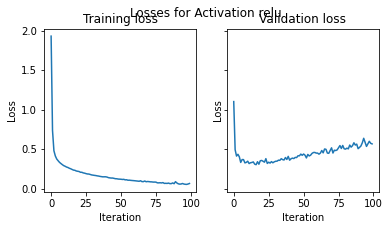

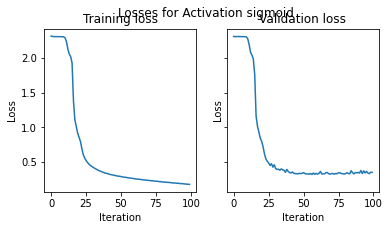

In [ ]:
import matplotlib.pyplot as plt

for i in range(2):  ##plotted only for relu and sigmoid(first 2 activations)
  fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
  axs[0].plot(Fmodels[i].train_loss)
  axs[0].set_title("Training loss")
  axs[0].set_xlabel("Iteration")
  axs[0].set_ylabel("Loss")
  axs[1].plot(Fmodels[i].val_loss)
  axs[1].set_title("Validation loss")
  axs[1].set_xlabel("Iteration")
  axs[1].set_ylabel("Loss")
  fig.suptitle(f'Losses for Activation {actF[i]}')
  plt.show()

In [ ]:
# code to import saved models and check accuracy on test data
actF = ['relu', 'sigmoid', 'linear', 'tanh']
ep=[50,100]
for i in range(4):
  activation=actF[i]
  model=Fmodels[i]
  nn=MyNeuralNetwork(n_layers=5, layer_sizes=[784,256,128,64,10], activation=activation, learning_rate=0.1, weight_init='normal', batch_size=32, num_epochs=100)
  for e in ep:
    p_namew=f"{e}_{activation}_weights.pkl"
    p_nameb=f"{e}_{activation}_biases.pkl"
    nn.W=pickle.load(open(p_namew, "rb"))  # loading the saved weights and replacing putting them in the architecture
    nn.B=pickle.load(open(p_nameb, "rb"))
    print(f"Score of model with {activation} on {e}th epoch={nn.score(x_test,y_test)}")  # getting the scores of the models

Score of model with relu on 50th epoch=0.8971666666666667
Score of model with relu on 100th epoch=0.8931666666666667
Score of model with sigmoid on 50th epoch=0.8713333333333333
Score of model with sigmoid on 100th epoch=0.8905
Score of model with linear on 50th epoch=0.099
Score of model with linear on 100th epoch=0.099
Score of model with tanh on 50th epoch=0.8898333333333334
Score of model with tanh on 100th epoch=0.8828333333333334


### 1.6

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Training with relu activation done
Saved the model


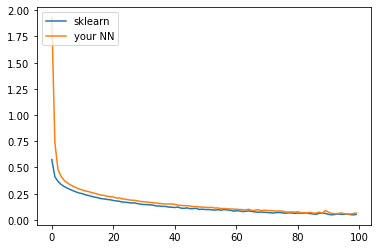

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Training with relu activation done


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Training with logistic activation done
Saved the model


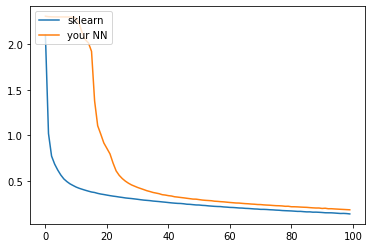

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:291: RuntimeWarning: invalid value encountered in double_scalars
  loss += (0.5 * self.alpha) * values / n_samples


Training with logistic activation done


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Training with identity activation done
Saved the model


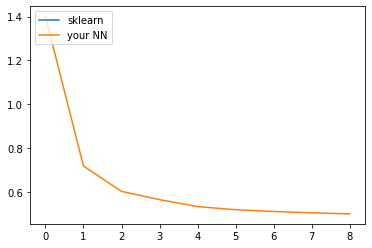

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_base.py:66: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Training with identity activation done


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Training with tanh activation done
Saved the model


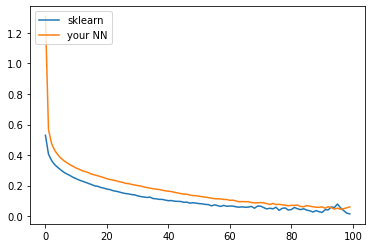

Training with tanh activation done


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [15]:
# comparing with MLP
actF = ['relu', 'sigmoid', 'linear', 'tanh']
sklearn_act=['relu','logistic', 'identity','tanh']  # storing the names which are given as parameters to sklearn libraries
for i in range(4):
  mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation=sklearn_act[i],solver='sgd',alpha=0,batch_size=32,max_iter=100, learning_rate_init = 0.1, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False)
  mlp.fit(Xtrain,ytrain)
  print(f"Training with {sklearn_act[i]} activation done")

  p_name=f"sklearn_{sklearn_act[i]}_100.pkl"
  f3=open(p_name, "wb")
  pickle.dump(mlp,f3)
  f3.close()
  print("Saved the model")

  loss_from_sklearn = mlp.loss_curve_
  plt.plot(loss_from_sklearn,label="sklearn")
  plt.plot(Fmodels[i].train_loss,label="your NN")
  plt.legend(loc="upper left")
  plt.savefig(f"result_{sklearn_act[i]}.png")
  plt.show()
  plt.close()

  mlp=MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation=sklearn_act[i],solver='sgd',alpha=0,batch_size=32,max_iter=50, learning_rate_init = 0.1, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False)
  mlp.fit(Xtrain,ytrain)
  print(f"Training with {sklearn_act[i]} activation done")
  p_name=f"sklearn_{sklearn_act[i]}_50.pkl"
  f3=open(p_name, "wb")
  pickle.dump(mlp,f3)
  f3.close()

In [16]:
## accuracy of own NN were shown before
# now loading and showing accuracies of models trained on sklearn
sklearn_act=['relu','logistic', 'identity','tanh']
it=[50,100]
for i in sklearn_act:
  for ni in it:
    p_name=f"sklearn_{i}_{ni}.pkl"
    mnn=pickle.load(open(p_name, "rb"))
    print(f"Score of sklearn model trained with {i} at {ni}th epoch = {mnn.score(x_test,y_test)}")

Score of sklearn model trained with relu at 50th epoch = 0.8968333333333334
Score of sklearn model trained with relu at 100th epoch = 0.9001666666666667
Score of sklearn model trained with logistic at 50th epoch = 0.8846666666666667
Score of sklearn model trained with logistic at 100th epoch = 0.8935
Score of sklearn model trained with identity at 50th epoch = 0.099
Score of sklearn model trained with identity at 100th epoch = 0.099
Score of sklearn model trained with tanh at 50th epoch = 0.8813333333333333
Score of sklearn model trained with tanh at 100th epoch = 0.8953333333333333
